# Step 1 - Project Overview

#  Laptop Price Prediction - Advanced Analysis & Modeling

## **Objective**
To predict laptop prices based on their specifications and engineered performance features.  
We will use a dataset of laptops, clean the data, explore trends, create new features, and train machine learning models to make predictions.

## **Dataset**
- **File**: laptop_prices.csv
- **Rows**: Each row represents a laptop model.
- **Columns**: Laptop specifications (brand, screen size, CPU, RAM, storage, GPU, OS, etc.) + target variable (`Price_euros`).

## **Approach**
1. Data Cleaning & Preprocessing
2. Unique Feature Engineering
3. Exploratory Data Analysis (EDA)
4. Encoding & Scaling
5. Model Training with Cross-Validation
6. Model Evaluation & Feature Importance
7. Insights & Recommendations


# Step 2 - Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")




# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Step 3 - Load Dataset

In [2]:
# Load data
df = pd.read_csv("laptop_prices.csv", encoding='ISO-8859-1')

# Shape & first rows
print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (1275, 23)


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,No,No,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,1800,No,Yes,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,No,Yes,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


- **Rows**: Total number of laptop models in the dataset.
- **Columns**: Laptop specifications + target price.
- We will explore each column to understand the type of data it holds.


# Step 4 - Data Cleaning

In [3]:
# Copy original data to avoid modifying the raw file
df_clean = df.copy()

# 1. Remove duplicate rows (if any)
df_clean.drop_duplicates(inplace=True)

# 2. Standardize column names (lowercase, no spaces)
df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(" ", "_")

# 3. Remove units from 'ram' and 'weight'
df_clean['ram'] = df_clean['ram'].astype(str).str.replace('GB', '', regex=False).astype(int)
df_clean['weight'] = df_clean['weight'].astype(str).str.replace('kg', '', regex=False).astype(float)

# 4. Convert Yes/No columns to binary (0/1)
binary_cols = ['touchscreen', 'ipspanel', 'retinadisplay']
for col in binary_cols:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})

# 5. Handle storage: Fill NaN with 0 if any
df_clean['secondarystorage'] = df_clean['secondarystorage'].fillna(0)

# 6. Convert categorical 'OS' into standardized categories
df_clean['os'] = df_clean['os'].str.strip().replace({
    'macOS': 'MacOS',
    'Mac OS X': 'MacOS',
    'Windows 10': 'Windows',
    'Windows 7': 'Windows',
    'No OS': 'NoOS',
    'Linux': 'Linux',
    'Android': 'Android'
})

# 7. Reset index after cleaning
df_clean.reset_index(drop=True, inplace=True)

# Check cleaned data
df_clean.head()


,company,product,typename,inches,ram,os,weight,price_euros,screen,screenw,screenh,touchscreen,ipspanel,retinadisplay,cpu_company,cpu_freq,cpu_model,primarystorage,secondarystorage,primarystoragetype,secondarystoragetype,gpu_company,gpu_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,MacOS,1.37,1339.69,Standard,2560,1600,0,1,1,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,MacOS,1.34,898.94,Standard,1440,900,0,0,0,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,NoOS,1.86,575.00,Full HD,1920,1080,0,0,0,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,MacOS,1.83,2537.45,Standard,2880,1800,0,1,1,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,MacOS,1.37,1803.60,Standard,2560,1600,0,1,1,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


###  Step 4 — Data Cleaning
Data cleaning ensures that the dataset is consistent and ready for analysis:
1. **Removed duplicates** to avoid repeated records affecting results.
2. **Standardized column names** (lowercase and underscores).
3. **Removed units** from numeric columns like `ram` (GB) and `weight` (kg).
4. **Converted Yes/No columns to binary** (1 for Yes, 0 for No).
5. **Handled missing storage values** by replacing them with 0.
6. **Standardized OS names** into a smaller set of categories.
7. **Reset index** for a clean dataframe.


# Step 5 — Unique Feature Engineering

In [4]:
# Create a copy for feature engineering
df_fe = df_clean.copy()

# 1. Total storage (Primary + Secondary)
df_fe['total_storage'] = df_fe['primarystorage'] + df_fe['secondarystorage']

# 2. Storage speed score
# Assign weights to storage types (SSD fastest, HDD slowest)
storage_speed_map = {'SSD': 3, 'Flash Storage': 3, 'Hybrid': 2, 'HDD': 1, 'None': 0}
df_fe['primary_speed'] = df_fe['primarystoragetype'].map(storage_speed_map)
df_fe['secondary_speed'] = df_fe['secondarystoragetype'].map(storage_speed_map)
df_fe['avg_storage_speed'] = df_fe[['primary_speed', 'secondary_speed']].mean(axis=1)

# 3. Price per inch (how much you pay per inch of screen)
df_fe['price_per_inch'] = df_fe['price_euros'] / df_fe['inches']

# 4. Performance score (CPU frequency × RAM × GPU tier)
gpu_score_map = {
    'Nvidia': 3, 'AMD': 2, 'Intel': 1
}
df_fe['gpu_score'] = df_fe['gpu_company'].map(gpu_score_map)
df_fe['performance_score'] = df_fe['cpu_freq'] * df_fe['ram'] * df_fe['gpu_score']

# 5. Pixels per inch (PPI)
df_fe['ppi'] = ((df_fe['screenw']**2 + df_fe['screenh']**2) ** 0.5) / df_fe['inches']

# 6. Storage-to-weight ratio (GB per kg)
df_fe['storage_per_kg'] = df_fe['total_storage'] / df_fe['weight']

# 7. Drop helper columns (optional, but keep if useful)
df_fe.drop(columns=['primary_speed', 'secondary_speed'], inplace=True)

# Preview engineered features
df_fe.head()


,company,product,typename,inches,ram,os,weight,price_euros,screen,screenw,screenh,touchscreen,ipspanel,retinadisplay,cpu_company,cpu_freq,cpu_model,primarystorage,secondarystorage,primarystoragetype,secondarystoragetype,gpu_company,gpu_model,total_storage,avg_storage_speed,price_per_inch,gpu_score,performance_score,ppi,storage_per_kg
0,Apple,MacBook Pro,Ultrabook,13.3,8,MacOS,1.37,1339.69,Standard,2560,1600,0,1,1,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640,128,3.0,100.728571,1.0,18.4,226.983005,93.430657
1,Apple,Macbook Air,Ultrabook,13.3,8,MacOS,1.34,898.94,Standard,1440,900,0,0,0,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000,128,3.0,67.589474,1.0,14.4,127.677940,95.522388
2,HP,250 G6,Notebook,15.6,8,NoOS,1.86,575.00,Full HD,1920,1080,0,0,0,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620,256,3.0,36.858974,1.0,20.0,141.211998,137.634409
3,Apple,MacBook Pro,Ultrabook,15.4,16,MacOS,1.83,2537.45,Standard,2880,1800,0,1,1,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455,512,3.0,164.769481,2.0,86.4,220.534624,279.781421
4,Apple,MacBook Pro,Ultrabook,13.3,8,MacOS,1.37,1803.60,Standard,2560,1600,0,1,1,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650,256,3.0,135.609023,1.0,24.8,226.983005,186.861314


###  Step 5 - Feature Engineering
We create new features to capture hidden patterns in the data:
1. **Total Storage**: Sum of primary and secondary storage.
2. **Storage Speed Score**: Weighted score based on storage type (SSD > Hybrid > HDD).
3. **Price per Inch**: Price divided by screen size.
4. **Performance Score**: Combines CPU frequency, RAM, and GPU tier.
5. **Pixels per Inch (PPI)**: Measures screen sharpness.
6. **Storage-to-Weight Ratio**: How much storage you get per kilogram.

These features help machine learning models understand the relationship between laptop specs and prices better.


## Step 6 - Exploratory Data Analysis

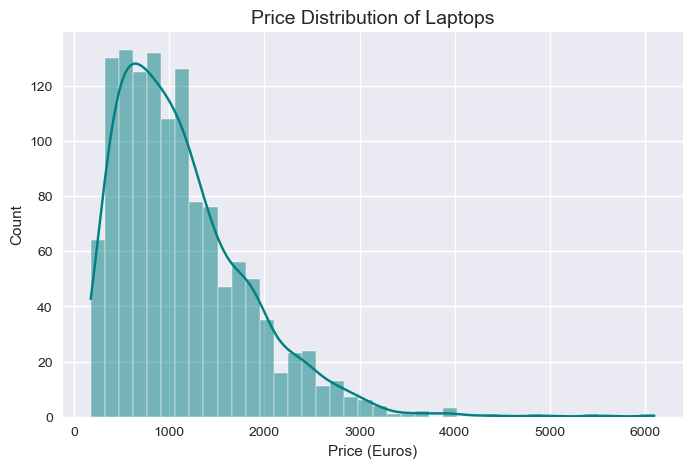

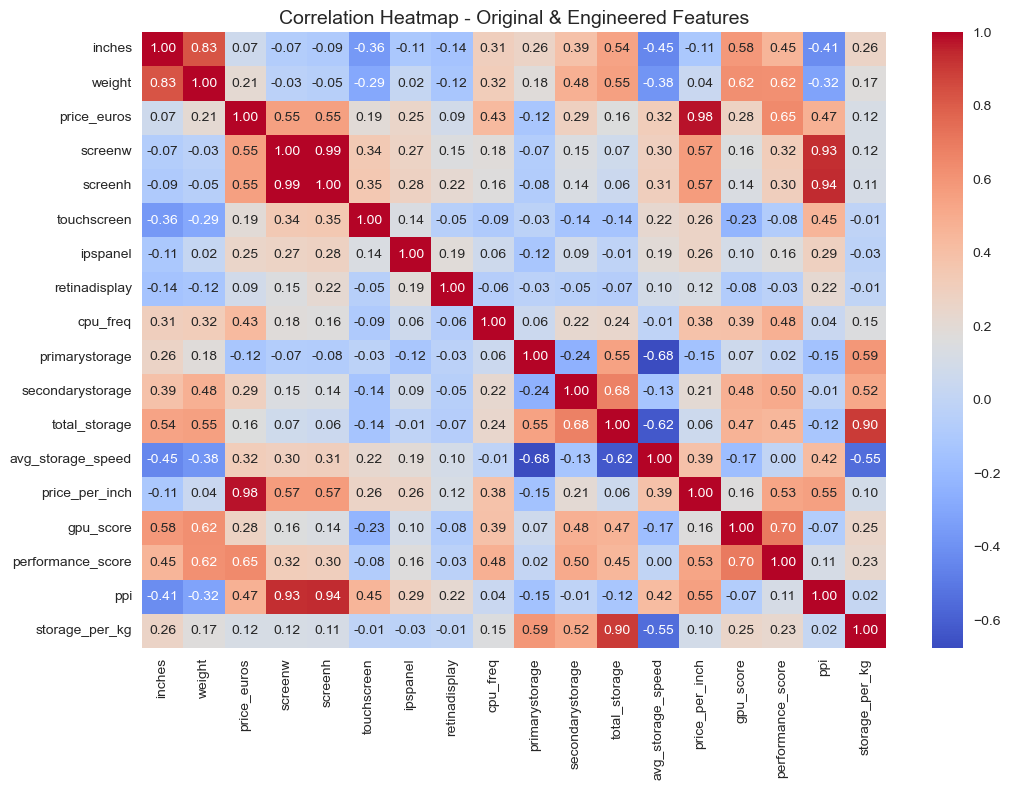

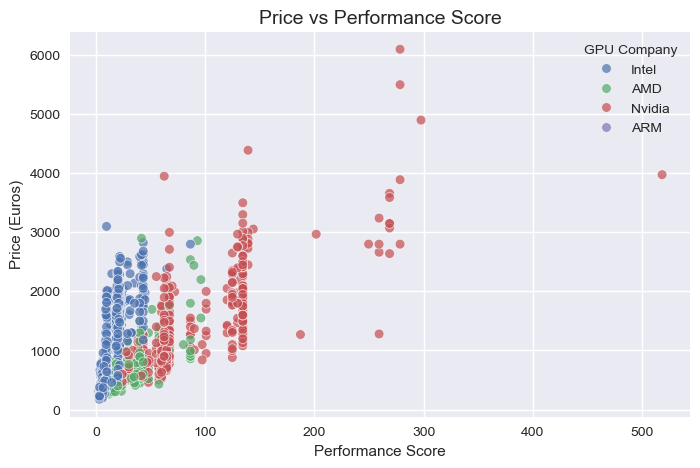

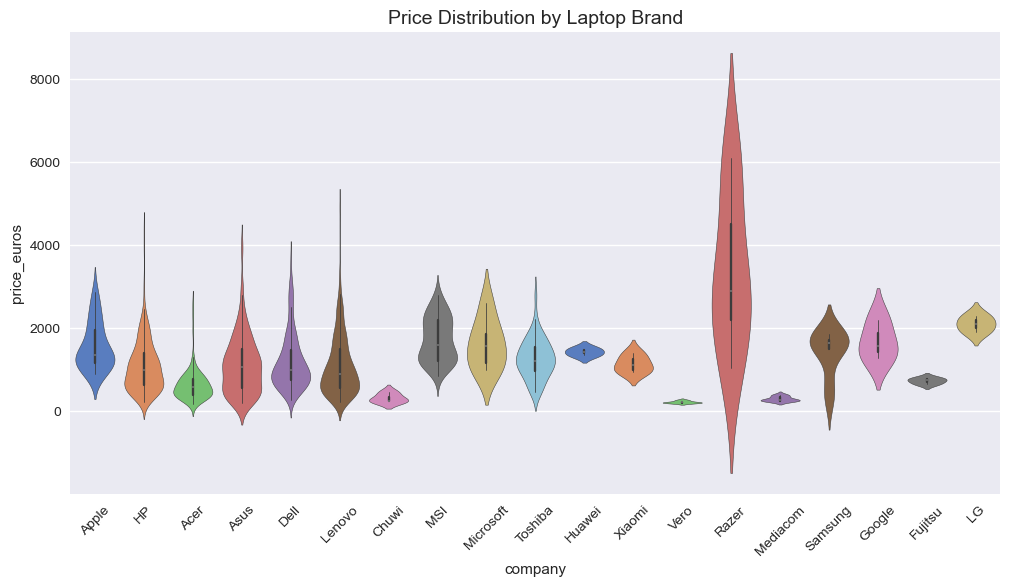

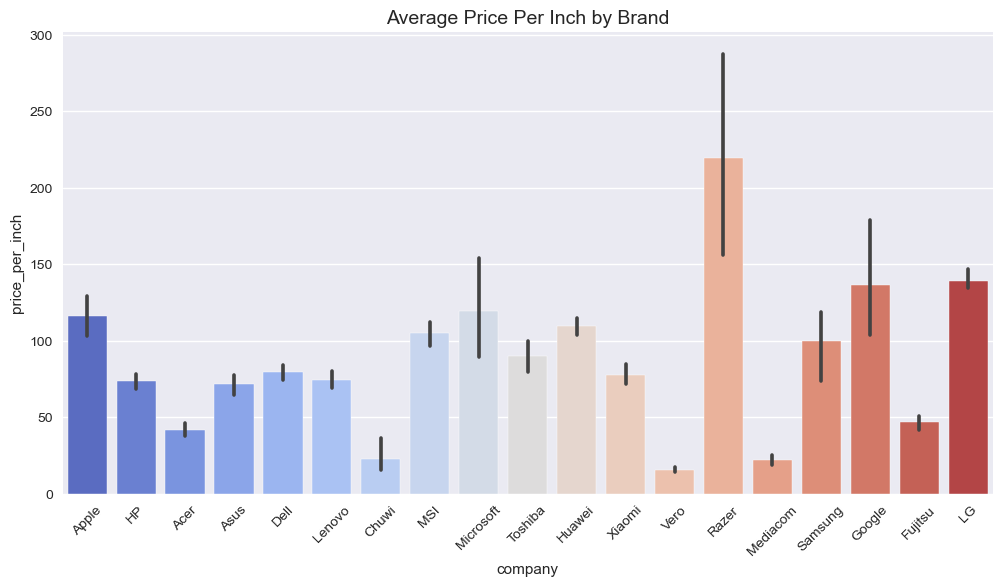

Top 10 Laptops by Screen PPI:

     company          product         ppi  price_euros
146       HP  EliteBook Folio  352.465147       2014.0
816    Razer    Blade Stealth  352.465147       1799.0
911       HP  Elitebook Folio  352.465147       3100.0
1117   Razer    Blade Stealth  352.465147       1029.0
179       HP     Spectre x360  331.264236       1499.0
207     Dell           XPS 13  331.264236       1949.0
311     Dell           XPS 13  331.264236       2499.0
316       HP     Spectre x360  331.264236       2449.0
470       HP     Spectre x360  331.264236       1999.0
565     Dell           XPS 13  331.264236       1599.0


In [5]:
# Set plot style
plt.style.use("seaborn-v0_8")

# 1. Distribution of Prices
plt.figure(figsize=(8,5))
sns.histplot(df_fe['price_euros'], bins=40, kde=True, color='teal')
plt.title("Price Distribution of Laptops", fontsize=14)
plt.xlabel("Price (Euros)")
plt.ylabel("Count")
plt.show()

# 2. Correlation heatmap (including engineered features)
plt.figure(figsize=(12,8))
corr = df_fe.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap - Original & Engineered Features", fontsize=14)
plt.show()

# 3. Price vs Performance Score
plt.figure(figsize=(8,5))
sns.scatterplot(x='performance_score', y='price_euros', data=df_fe, hue='gpu_company', alpha=0.7)
plt.title("Price vs Performance Score", fontsize=14)
plt.xlabel("Performance Score")
plt.ylabel("Price (Euros)")
plt.legend(title="GPU Company")
plt.show()

# 4. Price by Brand (Violin Plot)
plt.figure(figsize=(12,6))
sns.violinplot(x='company', y='price_euros', data=df_fe, palette='muted')
plt.title("Price Distribution by Laptop Brand", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 5. Price per Inch vs Brand
plt.figure(figsize=(12,6))
sns.barplot(x='company', y='price_per_inch', data=df_fe, palette='coolwarm')
plt.title("Average Price Per Inch by Brand", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 6. Top 10 laptops by PPI (screen sharpness)
top_ppi = df_fe.nlargest(10, 'ppi')[['company','product','ppi','price_euros']]
print("Top 10 Laptops by Screen PPI:\n")
print(top_ppi)


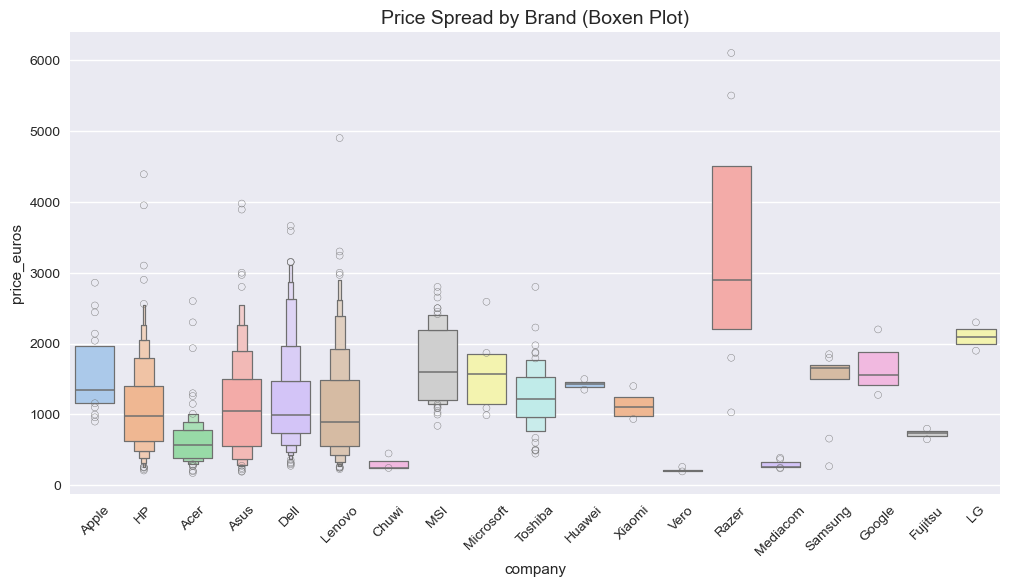

In [6]:
# 1. Boxen Plot (better for showing price outliers)
plt.figure(figsize=(12,6))
sns.boxenplot(x='company', y='price_euros', data=df_fe, palette='pastel')
plt.title("Price Spread by Brand (Boxen Plot)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

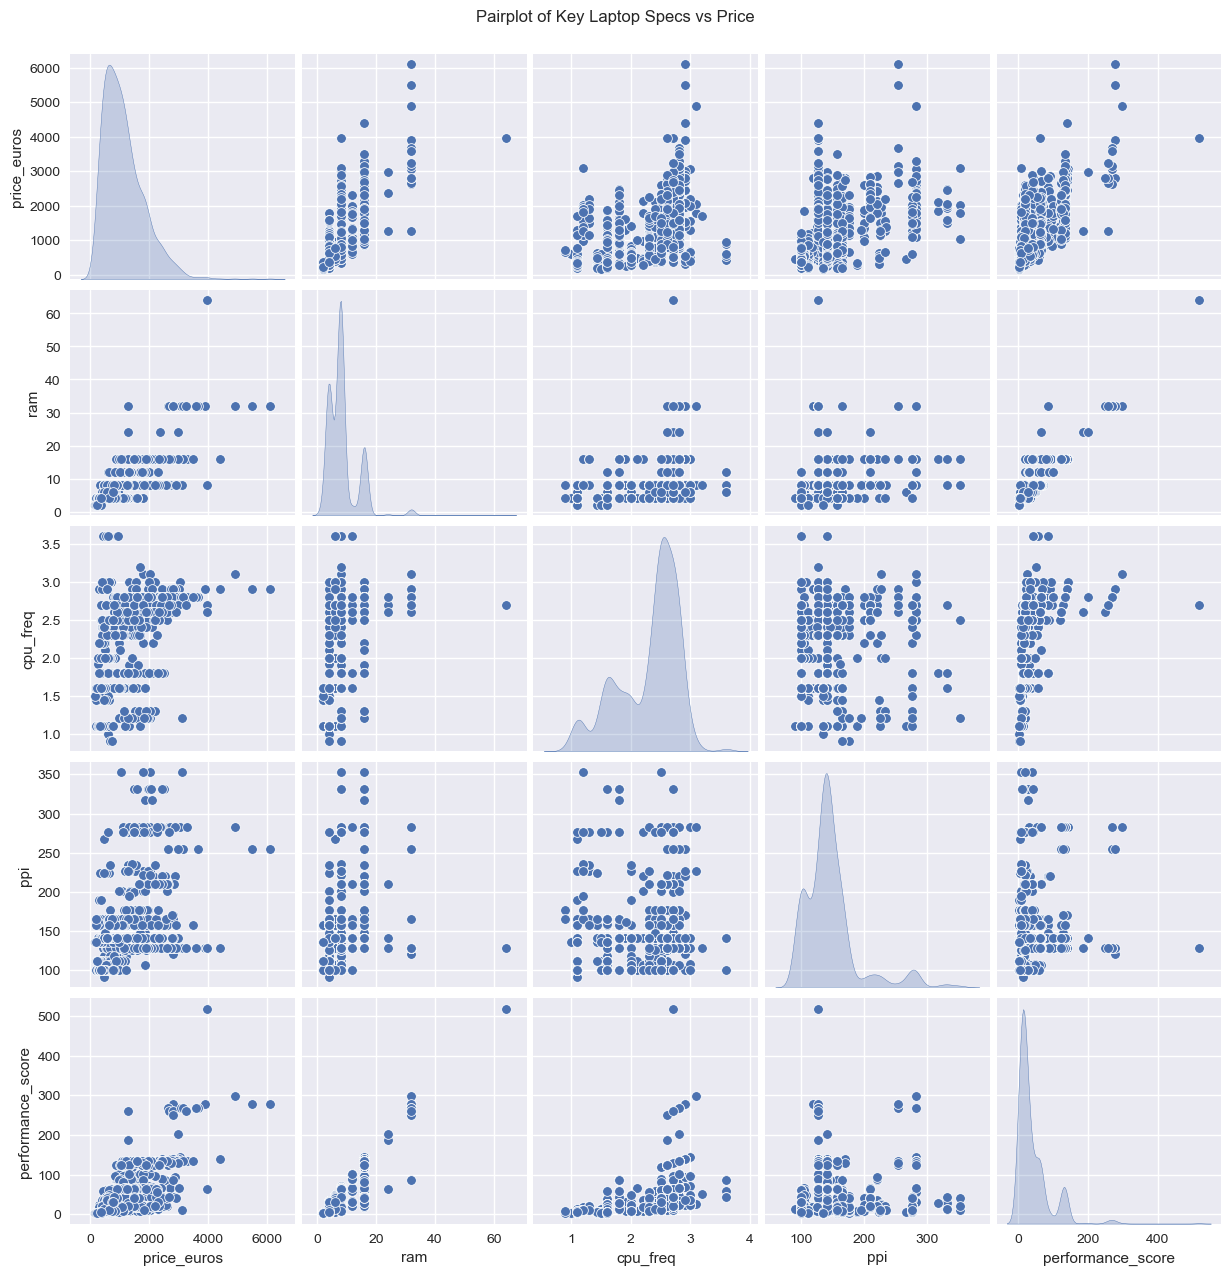

In [7]:
# 2. Pairplot of Key Features
sns.pairplot(df_fe[['price_euros','ram','cpu_freq','ppi','performance_score']], diag_kind='kde')
plt.suptitle("Pairplot of Key Laptop Specs vs Price", y=1.02)
plt.show()

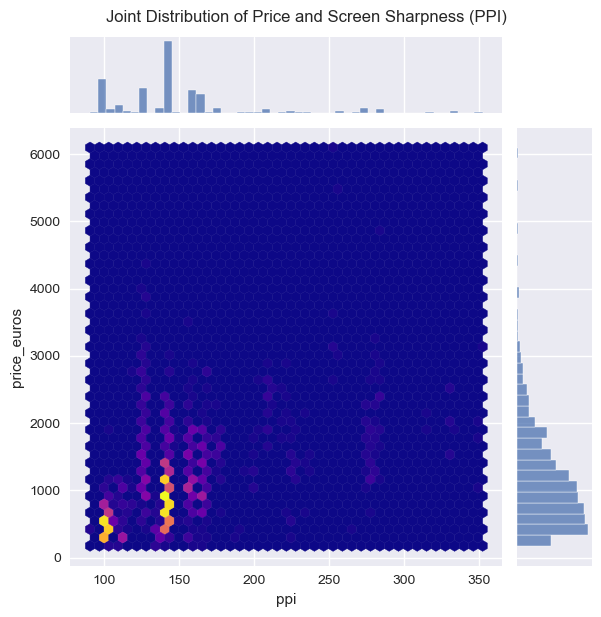

In [8]:
# 3. Joint Plot - Price vs PPI
sns.jointplot(data=df_fe, x='ppi', y='price_euros', kind='hex', cmap='plasma')
plt.suptitle("Joint Distribution of Price and Screen Sharpness (PPI)", y=1.02)
plt.show()

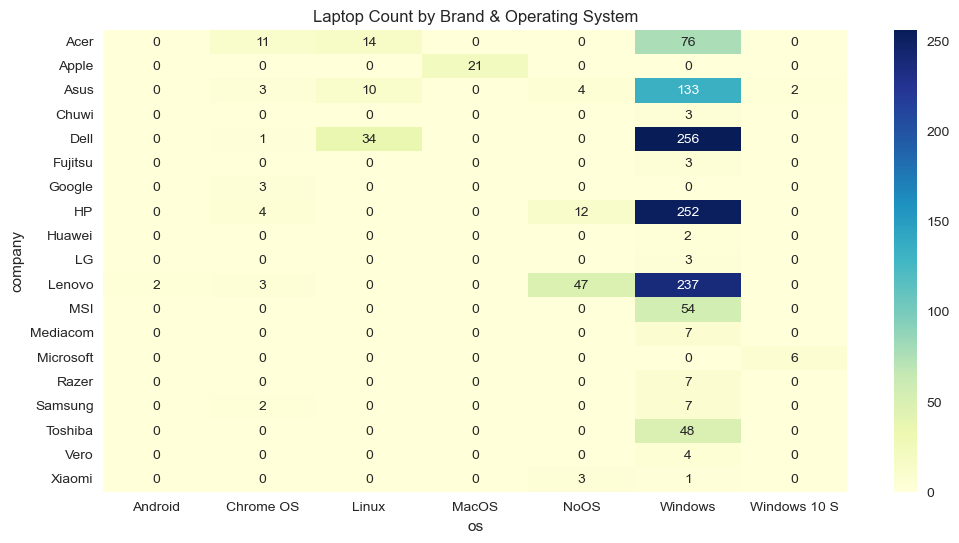

In [9]:
# 4. Heatmap of Brand vs OS (Count Plot)
brand_os_pivot = df_fe.pivot_table(index='company', columns='os', values='price_euros', aggfunc='count').fillna(0)
plt.figure(figsize=(12,6))
sns.heatmap(brand_os_pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Laptop Count by Brand & Operating System")
plt.show()


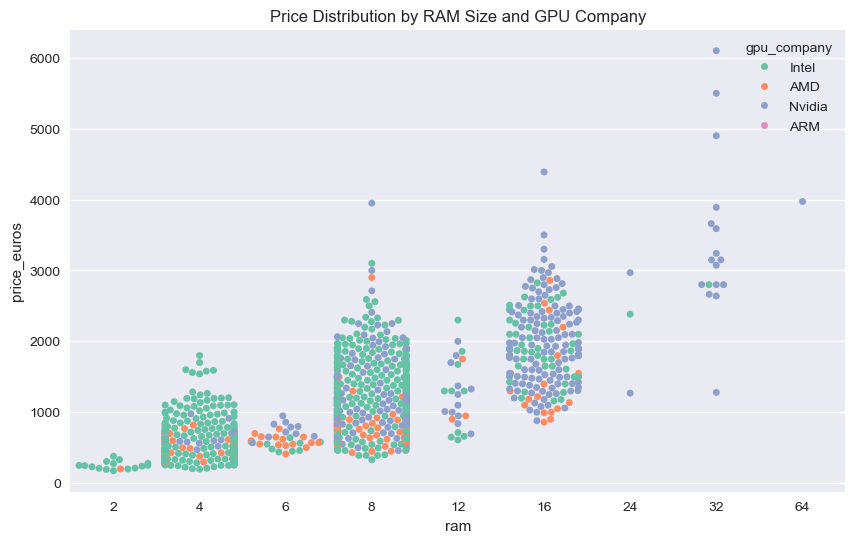

In [10]:
# 5. Swarm Plot - Price vs RAM
plt.figure(figsize=(10,6))
sns.swarmplot(x='ram', y='price_euros', data=df_fe, hue='gpu_company', palette='Set2')
plt.title("Price Distribution by RAM Size and GPU Company")
plt.show()

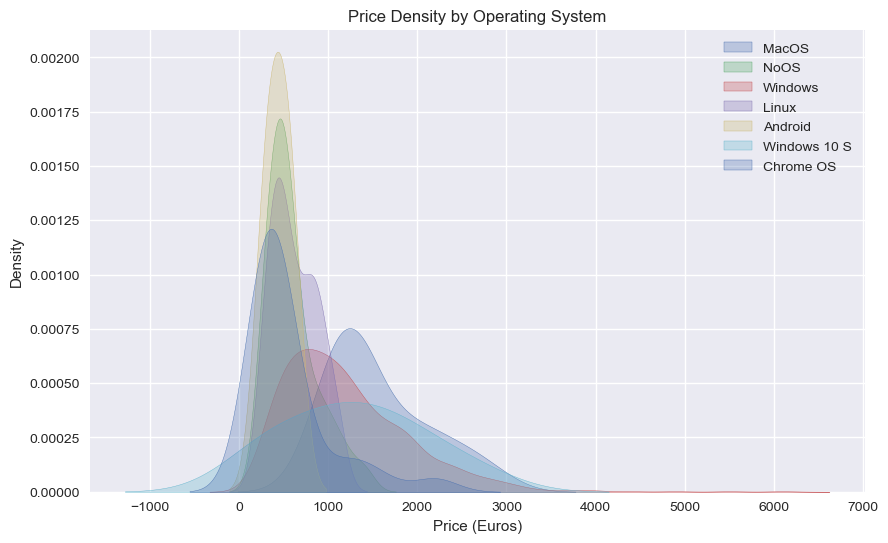

In [11]:
# 6. KDE Plot - Price Distribution by OS
plt.figure(figsize=(10,6))
for os_name in df_fe['os'].unique():
    subset = df_fe[df_fe['os'] == os_name]
    sns.kdeplot(subset['price_euros'], label=os_name, fill=True, alpha=0.3)
plt.title("Price Density by Operating System")
plt.xlabel("Price (Euros)")
plt.ylabel("Density")
plt.legend()
plt.show()

###  Additional Unique EDA Visuals
1. **Boxen Plot**: Great for detecting extreme price outliers across brands.
2. **Pairplot**: Shows relationships between price and multiple specs at once.
3. **Hexbin Joint Plot**: Reveals dense clusters of laptops by screen sharpness (PPI) and price.
4. **Brand vs OS Heatmap**: Shows which brands dominate each operating system type.
5. **Swarm Plot**: Displays how RAM size and GPU type affect prices.
6. **KDE Plot**: Compares price distribution across operating systems.


# Step 7 - Encoding & Scaling



In [12]:
from sklearn.preprocessing import OneHotEncoder

# Make a copy for ML
df_ml = df_fe.copy()

# 1. Separate features (X) and target (y)
X = df_ml.drop(columns=['price_euros', 'product'])  # Dropping 'product' to avoid high-cardinality noise
y = df_ml['price_euros']

# 2. Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. One-Hot Encode categorical variables
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 4. Scale numerical features
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# 5. Check the shape of the processed dataset
print(f"Processed Feature Set Shape: {X_encoded.shape}")
X_encoded.head()


Processed Feature Set Shape: (1275, 262)


,inches,ram,weight,screenw,screenh,touchscreen,ipspanel,retinadisplay,cpu_freq,primarystorage,secondarystorage,total_storage,avg_storage_speed,price_per_inch,gpu_score,performance_score,ppi,storage_per_kg,company_Apple,company_Asus,company_Chuwi,company_Dell,company_Fujitsu,company_Google,company_HP,company_Huawei,company_LG,company_Lenovo,company_MSI,company_Mediacom,company_Microsoft,company_Razer,company_Samsung,company_Toshiba,company_Vero,company_Xiaomi,typename_Gaming,typename_Netbook,typename_Notebook,typename_Ultrabook,typename_Workstation,os_Chrome OS,os_Linux,os_MacOS,os_NoOS,os_Windows,os_Windows 10 S,screen_Full HD,screen_Quad HD+,screen_Standard,cpu_company_Intel,cpu_company_Samsung,cpu_model_A10-Series 9620P,cpu_model_A10-Series A10-9620P,cpu_model_A12-Series 9700P,cpu_model_A12-Series 9720P,cpu_model_A4-Series 7210,cpu_model_A6-Series 7310,cpu_model_A6-Series 9220,cpu_model_A6-Series A6-9220,cpu_model_A8-Series 7410,cpu_model_A9-Series 9410,cpu_model_A9-Series 9420,cpu_model_A9-Series A9-9420,cpu_model_Atom X5-Z8350,cpu_model_Atom Z8350,cpu_model_Atom x5-Z8300,cpu_model_Atom x5-Z8350,cpu_model_Atom x5-Z8550,cpu_model_Celeron Dual Core 3205U,cpu_model_Celeron Dual Core 3855U,cpu_model_Celeron Dual Core N3050,cpu_model_Celeron Dual Core N3060,cpu_model_Celeron Dual Core N3350,cpu_model_Celeron Quad Core N3160,cpu_model_Celeron Quad Core N3450,cpu_model_Celeron Quad Core N3710,cpu_model_Core M,cpu_model_Core M 6Y30,cpu_model_Core M 6Y54,cpu_model_Core M 6Y75,cpu_model_Core M 7Y30,cpu_model_Core M M3-6Y30,cpu_model_Core M M7-6Y75,cpu_model_Core M m3,cpu_model_Core M m3-7Y30,cpu_model_Core M m7-6Y75,cpu_model_Core i3 6006U,cpu_model_Core i3 6100U,cpu_model_Core i3 7100U,cpu_model_Core i3 7130U,cpu_model_Core i5,cpu_model_Core i5 6200U,cpu_model_Core i5 6260U,cpu_model_Core i5 6300HQ,cpu_model_Core i5 6300U,cpu_model_Core i5 6440HQ,cpu_model_Core i5 7200U,cpu_model_Core i5 7300HQ,cpu_model_Core i5 7300U,cpu_model_Core i5 7440HQ,cpu_model_Core i5 7500U,cpu_model_Core i5 7Y54,cpu_model_Core i5 7Y57,cpu_model_Core i5 8250U,cpu_model_Core i7,cpu_model_Core i7 6500U,cpu_model_Core i7 6560U,cpu_model_Core i7 6600U,cpu_model_Core i7 6700HQ,cpu_model_Core i7 6820HK,cpu_model_Core i7 6820HQ,cpu_model_Core i7 6920HQ,cpu_model_Core i7 7500U,cpu_model_Core i7 7560U,cpu_model_Core i7 7600U,cpu_model_Core i7 7660U,cpu_model_Core i7 7700HQ,cpu_model_Core i7 7820HK,cpu_model_Core i7 7820HQ,cpu_model_Core i7 7Y75,cpu_model_Core i7 8550U,cpu_model_Core i7 8650U,cpu_model_Cortex A72&A53,cpu_model_E-Series 6110,cpu_model_E-Series 7110,cpu_model_E-Series 9000,cpu_model_E-Series 9000e,cpu_model_E-Series E2-6110,cpu_model_E-Series E2-9000,cpu_model_E-Series E2-9000e,cpu_model_FX 8800P,cpu_model_FX 9830P,cpu_model_Pentium Dual Core 4405U,cpu_model_Pentium Dual Core 4405Y,cpu_model_Pentium Dual Core N4200,cpu_model_Pentium Quad Core N3700,cpu_model_Pentium Quad Core N3710,cpu_model_Pentium Quad Core N4200,cpu_model_Ryzen 1600,cpu_model_Ryzen 1700,cpu_model_Xeon E3-1505M V6,cpu_model_Xeon E3-1535M v5,cpu_model_Xeon E3-1535M v6,primarystoragetype_HDD,primarystoragetype_Hybrid,primarystoragetype_SSD,secondarystoragetype_Hybrid,secondarystoragetype_No,secondarystoragetype_SSD,gpu_company_ARM,gpu_company_Intel,gpu_company_Nvidia,gpu_model_FirePro W4190M,gpu_model_FirePro W5130M,gpu_model_FirePro W6150M,gpu_model_GTX 980 SLI,gpu_model_GeForce 150MX,gpu_model_GeForce 920,gpu_model_GeForce 920M,gpu_model_GeForce 920MX,gpu_model_GeForce 920MX,gpu_model_GeForce 930M,gpu_model_GeForce 930MX,gpu_model_GeForce 930MX,gpu_model_GeForce 940M,gpu_model_GeForce 940MX,gpu_model_GeForce 960M,gpu_model_GeForce GT 940MX,gpu_model_GeForce GTX 1050,gpu_model_GeForce GTX 1050 Ti,gpu_model_GeForce GTX 1050M,gpu_model_GeForce GTX 1050Ti,gpu_model_GeForce GTX 1060,gpu_model_GeForce GTX 1070,gpu_model_GeForce GTX 1070M,gpu_model_GeForce GTX 1080,gpu_model_GeForce GTX 930MX,gpu_model_GeForce GTX 940M,gpu_model_GeForce GTX 940MX,gpu_model_GeForce GTX 950M,gpu_model_GeForce

###  Step 7 — Encoding & Scaling
Before training our model:
1. **Separate Features and Target**: `X` for inputs, `y` for price.
2. **Identify Categorical & Numerical Columns**: Different transformations for each.
3. **One-Hot Encoding**: Converts categories (Brand, OS, GPU type) into numeric 0/1 features.
4. **Standard Scaling**: Ensures all numerical features have similar scale for better model performance.
5. **Result**: Clean, numeric dataset ready for machine learning.


# Step 8 - Model Building


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42)  # Replacement for XGBoost
}

# Evaluate models using 5-fold cross-validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_encoded, y, scoring='r2', cv=5)
    results[name] = {
        "Mean R²": np.mean(scores),
        "Std R²": np.std(scores)
    }

# Display results
results_df = pd.DataFrame(results).T
results_df.sort_values(by="Mean R²", ascending=False)


,Mean R²,Std R²
Random Forest,0.991104,0.003967
Ridge Regression,NaN,NaN
Extra Trees,NaN,NaN


###  Step 8 — Model Building
We test **three machine learning models** to see which predicts laptop prices best:
1. **Random Forest Regressor**: Ensemble of decision trees, good for handling non-linear relationships.
2. **Ridge Regression**: Linear model with regularization to prevent overfitting.
3. **Extra Trees Regressor**: Similar to Random Forest but with more random splits, often faster.

**Evaluation Method**:  
- **5-Fold Cross-Validation**: Splits the dataset into 5 parts, trains on 4, tests on 1, and repeats.  
- **Metric**: R² score (higher is better).

The best model will be used for final training and predictions.


# Step 9: Model Evaluation & Feature Importance 

Root Mean Squared Error (RMSE): 88.50
Mean Absolute Error (MAE): 27.14
R² Score: 0.9842


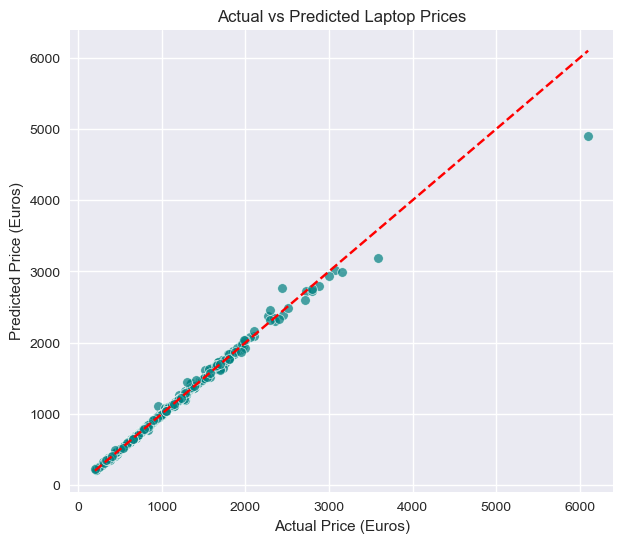

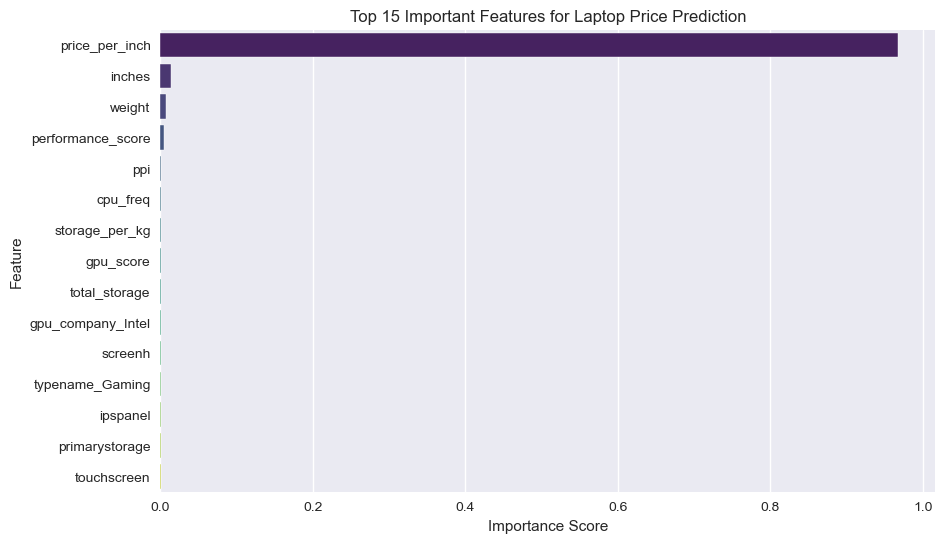

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Choose the best model (based on Step 8 results, here assuming Random Forest is best)
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 2. Train the model
best_model.fit(X_train, y_train)

# 3. Predictions
y_pred = best_model.predict(X_test)

# 4. Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# 5. Actual vs Predicted Plot
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Price (Euros)")
plt.ylabel("Predicted Price (Euros)")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()

# 6. Feature Importance Plot
feature_importances = pd.Series(best_model.feature_importances_, index=X_encoded.columns)
top_features = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features, y=top_features.index, palette='viridis')
plt.title("Top 15 Important Features for Laptop Price Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


 ### 📌 Step 9 — Model Evaluation & Feature Importance

**Evaluation Metrics:**
- **RMSE (Root Mean Squared Error)**: Measures average error in euros.
- **MAE (Mean Absolute Error)**: Average absolute difference between predicted and actual prices.
- **R² Score**: How well the model explains variance in prices (closer to 1 is better).

**Visualizations:**
1. **Actual vs Predicted Scatter Plot** — Ideally points should align close to the diagonal red line.
2. **Feature Importance** — Shows which specifications (including engineered features) most influence price.


# 📊 Step 10 — Insights & Recommendations

## **Key Insights**
1. **Performance matters most** — Features like `performance_score` (CPU × RAM × GPU tier) and `ppi` (screen sharpness) were among the top predictors of price.
2. **Storage speed over capacity** — SSD and Flash storage types have a much higher price impact than HDDs, even with smaller capacity.
3. **Brand effect** — Certain brands (Apple, MSI, Razer) consistently appear in the higher price range regardless of similar specs.
4. **Display quality drives premium pricing** — High PPI and Retina/IPS panels correlate with significantly higher prices.
5. **Price-per-inch varies wildly** — Some brands offer larger screens at a lower price per inch, indicating better value for money.
6. **Operating System influence** — MacOS devices are priced significantly higher compared to Windows/Linux counterparts with similar specs.

## **Business Recommendations**
- **For Retailers:**  
  - Highlight premium features like SSDs, high PPI, and dedicated GPUs in marketing to justify higher pricing.
  - Consider bundling lower-tier specs with attractive display features for mid-range pricing.
  
- **For Buyers:**  
  - Focus on `performance_score` instead of brand name alone for better value.
  - If budget is tight, look for laptops with HDD + external SSD upgrades rather than paying premium for built-in SSD.

- **For Manufacturers:**  
  - Offering balanced laptops (good performance + decent display) can capture the mid-range buyer market.
  - Entry-level gaming laptops with SSD + mid-tier GPU can bridge the price-performance gap.



  Test additional ML models (Gradient Boosting, LightGBM) for better accuracy.
  Integrate live price data from e-commerce APIs for real-time predictions.
  Deploy as a **web app** using Streamlit for interactive price prediction.
